# Test AbacusSummit ELG and CMB lensing mock catalogues for cross-correlation

In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd
import healpy as hp
import pyccl as ccl
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'/home/tkarim/desi-lensing-cc/scripts/') #path to scripts
from utils import bin_mat

## Import files

In [3]:
#parameters
NSIDE = 2048
LMIN = 100
LMAX = 1024
ell = np.arange(0, LMAX, 1)

fsize = (20, 10)
fs = 20

In [4]:
#cmb 
kappa = hp.read_map("/mnt/store1/tkarim/kappa_ring_2048.fits")
mask_2048 = np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy")

#elg
elg = np.load("/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/products/gal_count_model_7_ring.npy")
elg_2048 = hp.ud_grade(elg, nside_out=NSIDE, power=-2) #convert elg map from 4096 to 2048
elg_2048 = elg_2048.astype(np.float64) #convert to float from int

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = EXPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


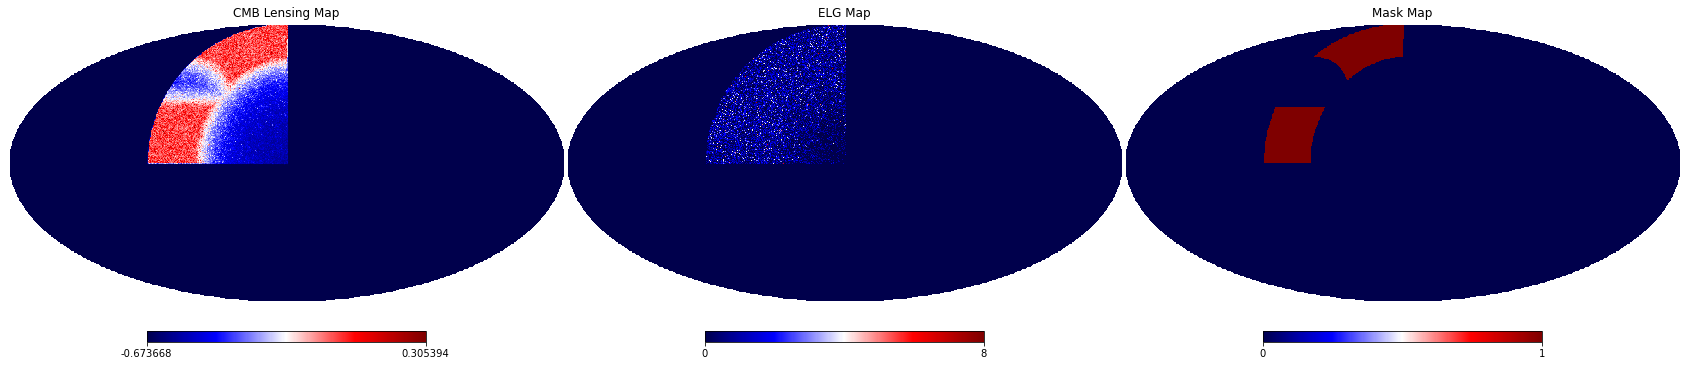

In [5]:
fg, ax = plt.subplots(ncols=3, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0])
hp.mollview(kappa, title = "CMB Lensing Map", hold = True, cmap = 'seismic')

plt.sca(ax[1])
hp.mollview(elg_2048, title = "ELG Map", hold = True, cmap = 'seismic')

plt.sca(ax[2])
hp.mollview(mask_2048, title = "Mask Map", hold = True, cmap = 'seismic')

### Apply mask

In [6]:
#cmb lensing
kappa_masked = hp.ma(kappa)
kappa_masked.mask = np.logical_not(mask_2048)

#elg
elg_masked = hp.ma(elg_2048)
elg_masked.mask = np.logical_not(mask_2048)

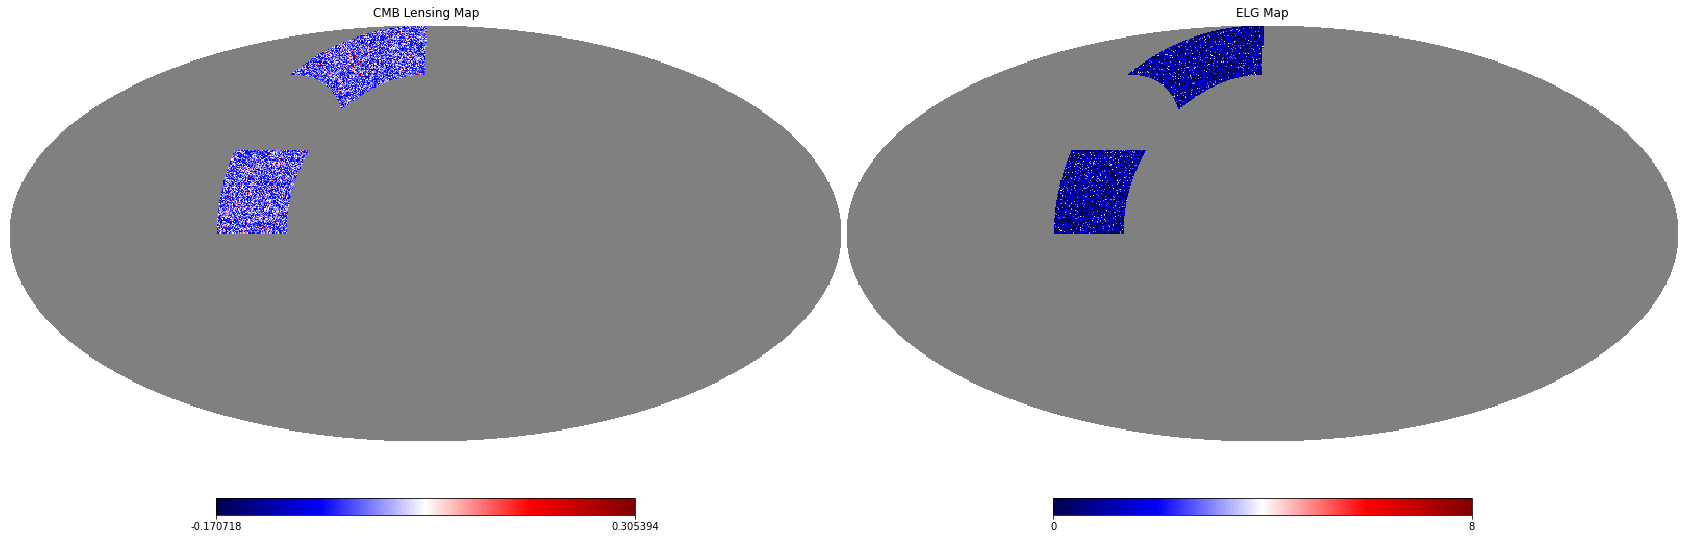

In [7]:
fg, ax = plt.subplots(ncols=2, figsize=(30, 20))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0])
hp.mollview(kappa_masked, title = "CMB Lensing Map", hold = True, cmap = 'seismic')

plt.sca(ax[1])
hp.mollview(elg_masked, title = "ELG Map", hold = True, cmap = 'seismic')

#### Calculate $f_{\rm sky}$

In [8]:
fsky = np.sum(mask_2048)/mask_2048.size
print(fsky)

0.04404143492380778


### Calculate $C_{l}$s 

In [9]:
#auto spectra
clkk = hp.anafast(kappa_masked, lmax = LMAX - 1, pol = False)
clgg = hp.anafast(elg_masked, lmax = LMAX - 1, pol = False)

#cross spectra
clkg = hp.anafast(kappa_masked, elg_masked, lmax = LMAX - 1, pol = False)

#### Calculate shot noise 

In [10]:
nbar = np.mean(elg_masked)/hp.nside2pixarea(nside=NSIDE)
N_gg = 1/nbar * np.ones_like(ell) #galaxy shot noise

(array([1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03]),
 <a list of 8 Text major ticklabel objects>)

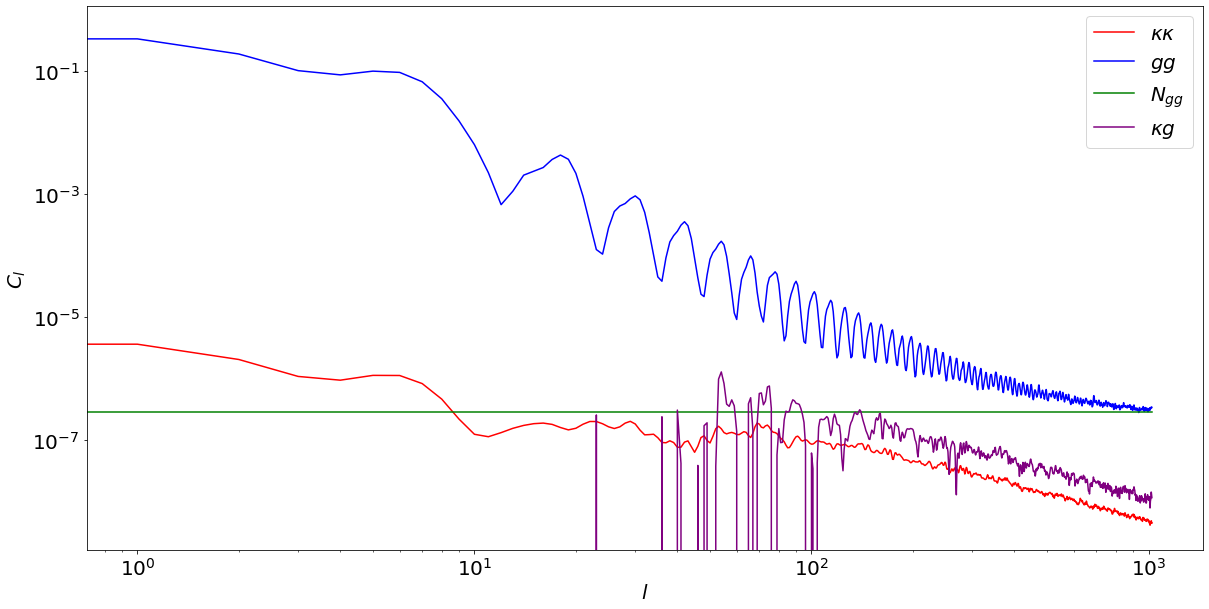

In [11]:
plt.figure(figsize = fsize)
plt.loglog(ell, clkk/fsky, label = r'$\kappa \kappa$', c = "r")
plt.loglog(ell, clgg/fsky, label = r'$gg$', c = "b")
plt.loglog(ell, N_gg, label = r'$N_{gg}$', c = "green")
plt.loglog(ell, clkg/fsky, label = r'$\kappa g$', c = "purple")
plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C_{l}$", fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

**Q: Why no signal in cross-correlation at $l < 11$?**

Bin plot to match Skylens 

In [12]:
ELL, CLkk = bin_mat(ell, clkk, np.arange(LMIN, LMAX, 100))
_, CLgg = bin_mat(ell, clgg, np.arange(LMIN, LMAX, 100))
_, CLkg = bin_mat(ell, clkg, np.arange(LMIN, LMAX, 100))
_, NLgg = bin_mat(ell, N_gg, np.arange(LMIN, LMAX, 100))

/home/tkarim/desi-lensing-cc/scripts/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 5 Text major ticklabel objects>)

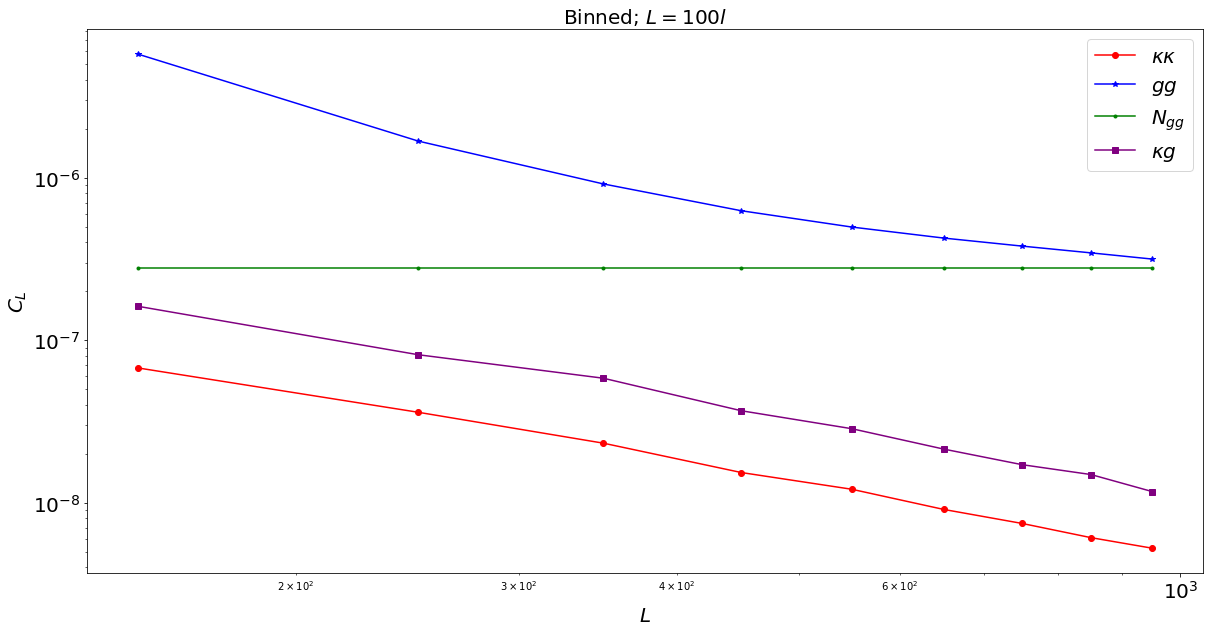

In [13]:
plt.figure(figsize = fsize)
plt.loglog(ELL, CLkk/fsky, label = r'$\kappa \kappa$', c = "r", marker = "o")
plt.loglog(ELL, CLgg/fsky, label = r'$gg$', c = "b", marker = "*")
plt.loglog(ELL, NLgg, label = r'$N_{gg}$', c = "g", marker = ".")
plt.loglog(ELL, CLkg/fsky, label = r'$\kappa g$', c = "purple", marker = "s")
plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$C_{L}$", fontsize = fs)
plt.title("Binned; $L = 100 l$", fontsize = fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)

#### Calculate theory using SkyLens

In [14]:
lb = np.array([150., 250., 350., 450., 550., 650., 750., 850., 950.])
skylens_kk = np.array([2.83407572e-09, 1.67304884e-09, 1.05095309e-09, 7.36325133e-10,
       5.47284585e-10, 4.23184824e-10, 3.42518969e-10, 2.82496610e-10,
       2.37455104e-10])

skylens_gg1 = np.array([2.58843794e-08, 1.39376771e-08, 8.61097740e-09, 5.85924649e-09,
       4.30066153e-09, 3.32466880e-09, 2.68232717e-09, 2.22928050e-09,
       1.88873152e-09])
skylens_kg1 = np.array([5.16070763e-09, 2.80275079e-09, 1.73979472e-09, 1.18042256e-09,
       8.68674185e-10, 6.70482663e-10, 5.40791013e-10, 4.48794946e-10,
       3.79835831e-10])

skylens_gg15 = np.array([5.82398536e-08, 3.13597734e-08, 1.93746991e-08, 1.31833046e-08,
       9.67648844e-09, 7.48050480e-09, 6.03523613e-09, 5.01588112e-09,
       4.24964592e-09])
skylens_kg15 = np.array([7.74106144e-09, 4.20412619e-09, 2.60969209e-09, 1.77063384e-09,
       1.30301128e-09, 1.00572399e-09, 8.11186519e-10, 6.73192420e-10,
       5.69753746e-10])

(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 5 Text major ticklabel objects>)

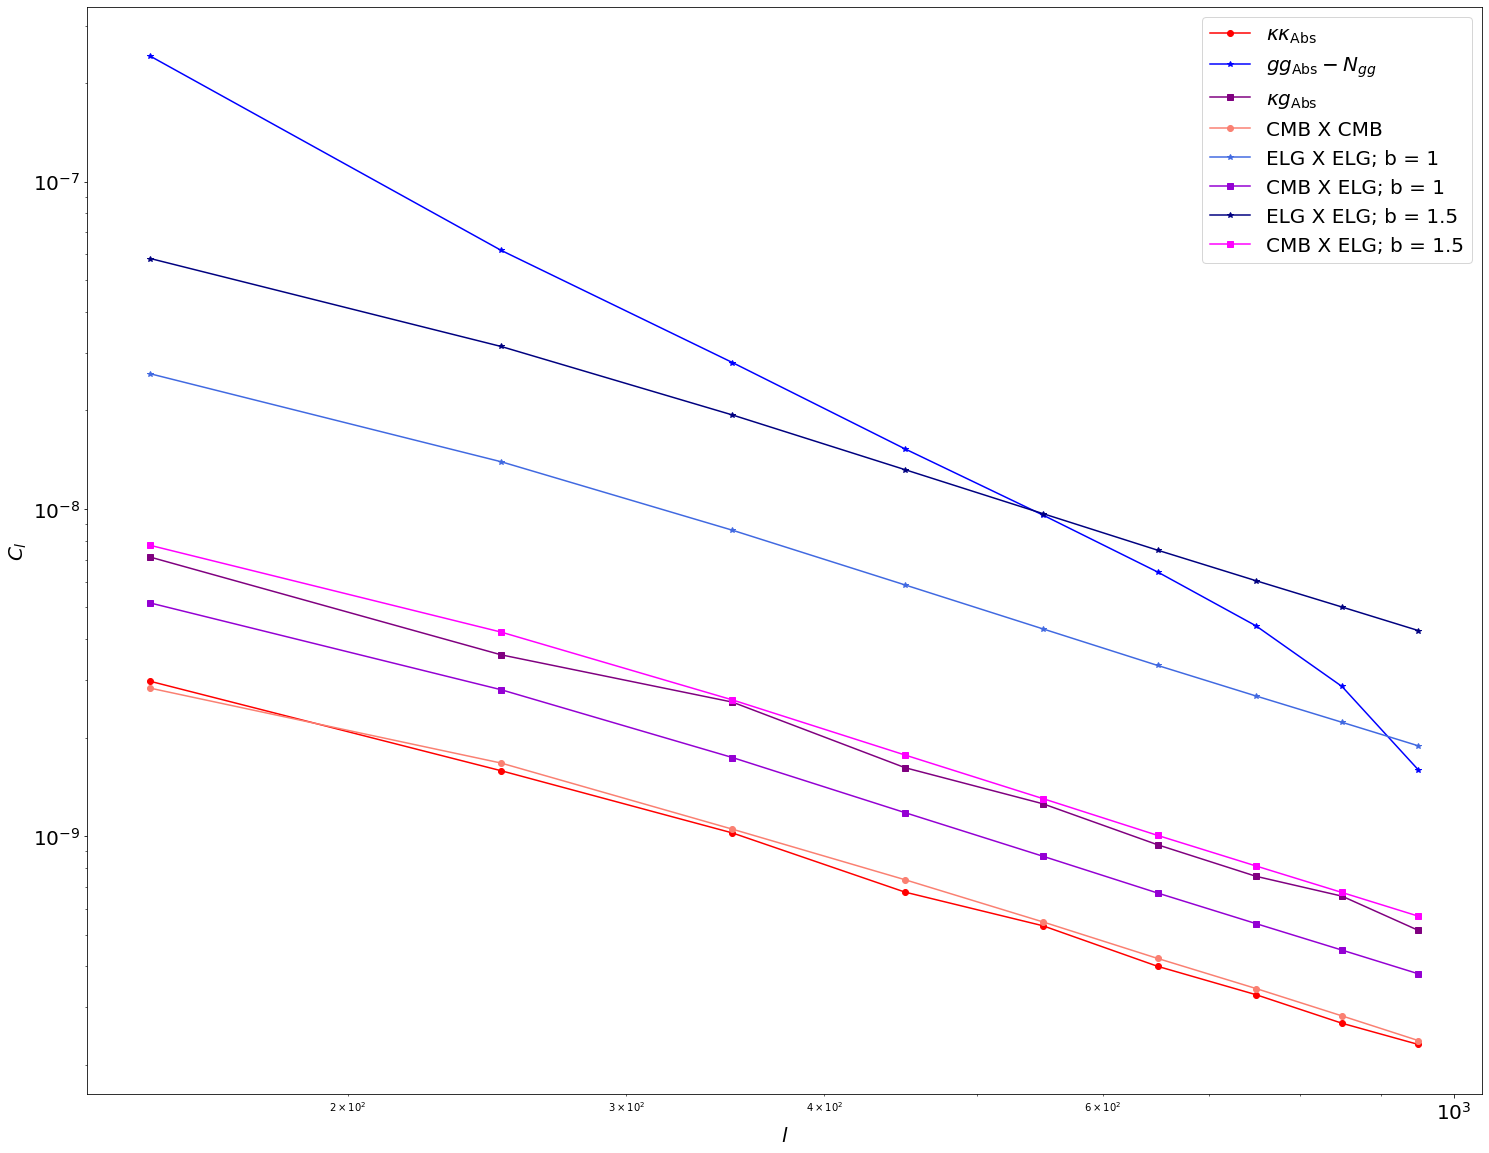

In [15]:
plt.figure(figsize = (25, 20))
plt.loglog(ELL[ELL > LMIN], CLkk[ELL > LMIN], label = r'$\kappa \kappa_{\rm Abs}$', c = "r", marker = "o")
plt.loglog(ELL[ELL > LMIN], CLgg[ELL > LMIN] - NLgg[ELL > LMIN]*np.mean(mask_2048), label = r'$gg_{\rm Abs} - N_{gg}$', c = "b", marker = "*")
plt.loglog(ELL[ELL > LMIN], CLkg[ELL > LMIN], label = r'$\kappa g_{\rm Abs}$', c = "purple", marker = "s")

plt.loglog(lb[lb > LMIN], skylens_kk[lb > LMIN], 'ro', ls = '-', label = "CMB X CMB", c = 'salmon')
plt.loglog(lb[lb > LMIN], skylens_gg1[lb > LMIN], 'b*', ls = '-', label = "ELG X ELG; b = 1", c = 'royalblue')
plt.loglog(lb[lb > LMIN], skylens_kg1[lb > LMIN], 'ms', ls = '-', label = "CMB X ELG; b = 1", c = 'darkviolet')

plt.loglog(lb[lb > LMIN], skylens_gg15[lb > LMIN], 'b*', ls = '-', label = "ELG X ELG; b = 1.5", c = 'navy')
plt.loglog(lb[lb > LMIN], skylens_kg15[lb > LMIN], 'ms', ls = '-', label = "CMB X ELG; b = 1.5", c = 'fuchsia')

plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C_{l}$", fontsize = fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)

Compare $\kappa \kappa$ measurement 

Text(0, 0.5, '$\\frac{C^{Abacus}_{l}}{C^{SkyLens}_{l}} - 1$')

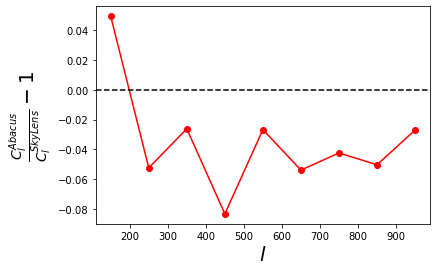

In [16]:
plt.plot(ELL[ELL > LMIN], CLkk[ELL > LMIN]/skylens_kk[lb > LMIN] - 1, 
           label = r'$\kappa \kappa_{\rm Abs}$', c = "r", marker = "o")
plt.axhline(0, c = 'k', ls = '--')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$\frac{C^{Abacus}_{l}}{C^{SkyLens}_{l}} - 1$", fontsize = fs)

In [17]:
np.mean(CLkk[ELL > LMIN]/skylens_kk[lb > LMIN]-1)

-0.034827413187487104

**Note: Why is the SkyLens $C_{\kappa \kappa}$ $\sim 3.4\%$ off from previous version?**

### Isolate window effects from power spectra

In [30]:
cosmo = ccl.Cosmology(Omega_b = 0.04930,
                      Omega_c = 0.26447, 
                      h = 0.6736,
                      A_s = 2.083e-9,
                      n_s = 0.9649,
                      Neff = 3.044,
                      w0 = -1.0, 
                      wa = 0.0, 
                      transfer_function='boltzmann_class')

In [31]:
#calculate theoretical Cls
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1100, )
cls_cmb_th = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

#read in dNdz
dNdzddeg2 = pd.read_csv("../../nz_blanc+abacus.txt", sep=",")

z = dNdzddeg2['Redshift_mid']
area = dNdzddeg2['abacus_area_deg2']
dNdz = dNdzddeg2['dndz/deg^2'] * area

#set constant bias
b = 1.5*np.ones(len(z))
#b15 = 1.5*np.ones(len(z))
#b1 = 1.*np.ones(len(z))

#Create CCL tracer object for galaxy clustering
elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
#elgl15 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b15))
#elgl1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b1))

#calculate theoretical Cls
cls_elg_th = ccl.angular_cl(cosmo, elgl, elgl, ell)

#calculate theoretical Cls
cls_cross_th = ccl.angular_cl(cosmo, elgl, cmbl, ell)
#cls_cross_th1 = ccl.angular_cl(cosmo, elgl1, cmbl, ell)
#cls_cross_th15 = ccl.angular_cl(cosmo, elgl15, cmbl, ell)

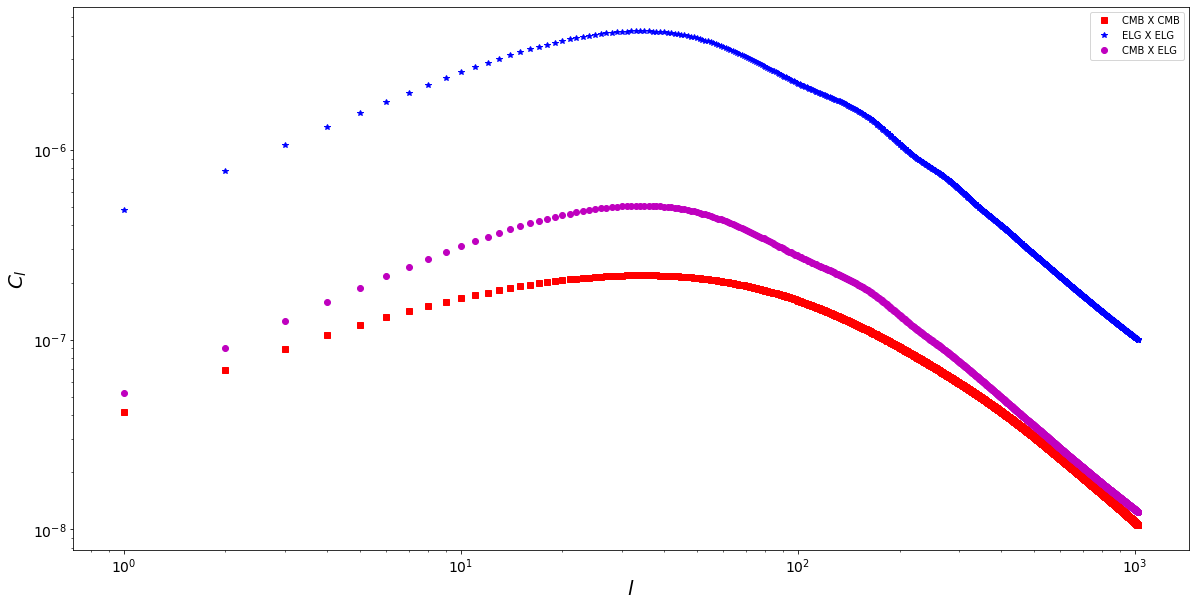

In [32]:
plt.figure(figsize=fsize)
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')

plt.plot(ell, cls_cmb_th, 'rs', label = "CMB X CMB")
plt.plot(ell, cls_elg_th, 'b*', label = "ELG X ELG")
plt.plot(ell, cls_cross_th, 'mo', label = "CMB X ELG")
plt.legend(loc = 'best')

## Pass $C_l$ from SkyLens

In [18]:
cls_cmb_th = np.array([6.48893356e-08, 3.67171646e-08, 2.28825535e-08, 1.60438891e-08,
       1.18870258e-08, 9.21249592e-09, 7.46284905e-09, 6.16512628e-09,
       5.23293308e-09, 4.51770790e-09, 3.95337551e-09, 3.50828847e-09,
       3.14216128e-09, 2.83998162e-09, 2.58671919e-09, 2.37070046e-09,
       2.18550331e-09, 2.02469591e-09, 1.88388520e-09, 1.75979475e-09,
       1.64953472e-09, 1.55101200e-09, 1.46248078e-09, 1.38249888e-09,
       1.30991744e-09, 1.24376513e-09, 1.18323354e-09, 1.12764793e-09,
       1.07643318e-09])

cls_cross_th = np.array([1.84203831e-07, 9.59901156e-08, 5.94106302e-08, 4.02509966e-08,
       2.96134979e-08, 2.28672950e-08, 1.84580598e-08, 1.53480037e-08,
       1.30932665e-08, 1.13886479e-08, 1.00668117e-08, 9.01450076e-09,
       8.15961057e-09, 7.45204269e-09, 6.85716963e-09, 6.34997890e-09,
       5.91231072e-09, 5.53053486e-09, 5.19437214e-09, 4.89582782e-09,
       4.62872406e-09, 4.38813906e-09, 4.17013684e-09, 3.97153816e-09,
       3.78975271e-09, 3.62259224e-09, 3.46829275e-09, 3.32537361e-09,
       3.19250809e-09])

cls_elg_th = np.array([1.39061080e-06, 7.18795468e-07, 4.42792047e-07, 3.00962903e-07,
       2.20767168e-07, 1.70686315e-07, 1.37783888e-07, 1.14701647e-07,
       9.79293451e-08, 8.52793349e-08, 7.54608284e-08, 6.76475774e-08,
       6.12970569e-08, 5.60391541e-08, 5.16161641e-08, 4.78425957e-08,
       4.45838975e-08, 4.17390142e-08, 3.92319206e-08, 3.70034325e-08,
       3.50078221e-08, 3.32087087e-08, 3.15769808e-08, 3.00891385e-08,
       2.87260499e-08, 2.74714665e-08, 2.63124159e-08, 2.52379890e-08,
       2.42382634e-08])

In [19]:
#generate synthetic map using theory Cls
m_k, m_g = hp.synfast((cls_cmb_th, cls_cross_th, cls_elg_th), NSIDE, lmax=LMAX-1, pol=False, verbose=False)

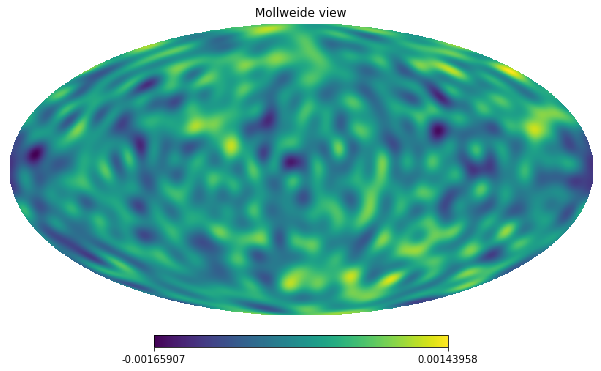

In [20]:
hp.mollview(m_k)

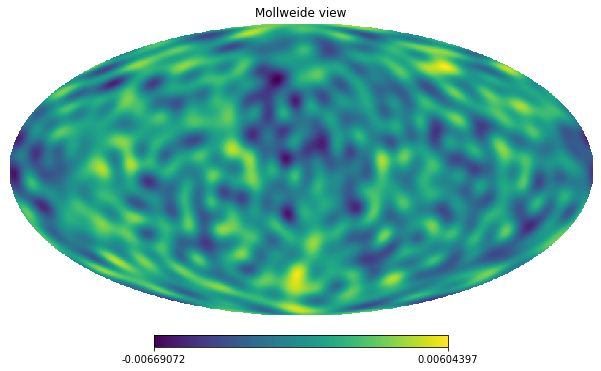

In [21]:
hp.mollview(m_g)

In [36]:
#cmb lensing
k_masked = hp.ma(m_k)
k_masked.mask = np.logical_not(mask_2048)

#elg
g_masked = hp.ma(m_g)
g_masked.mask = np.logical_not(mask_2048)

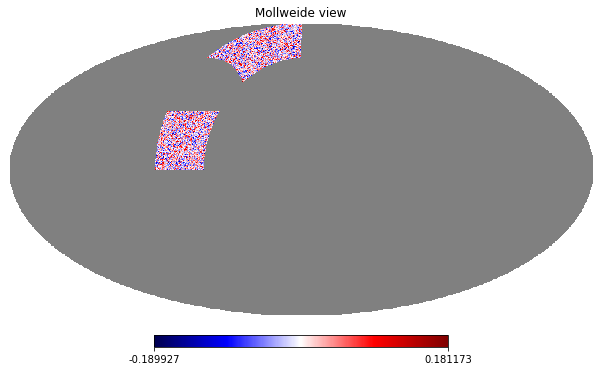

In [37]:
hp.mollview(k_masked, cmap = 'seismic')

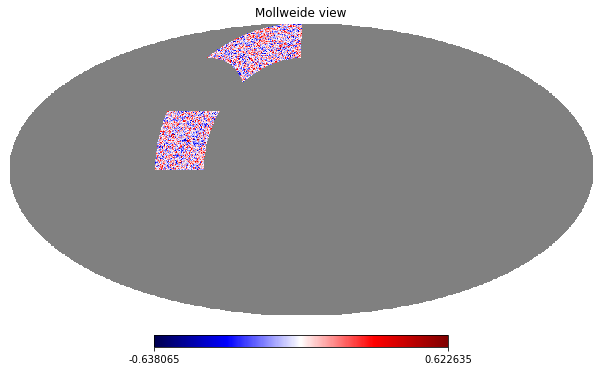

In [38]:
hp.mollview(g_masked, cmap = 'seismic')

In [39]:
#calculate Cls

#auto spectra
clkk_syn = hp.anafast(k_masked, lmax = LMAX - 1, pol = False)
clgg_syn = hp.anafast(g_masked, lmax = LMAX - 1, pol = False)

#cross spectra
clkg_syn = hp.anafast(k_masked, g_masked, lmax = LMAX - 1, pol = False)

In [40]:
#bin Cls

ELL, CLkk_syn = bin_mat(ell, clkk_syn, np.arange(LMIN, LMAX, 100))
_, CLgg_syn = bin_mat(ell, clgg_syn, np.arange(LMIN, LMAX, 100))
_, CLkg_syn = bin_mat(ell, clkg_syn, np.arange(LMIN, LMAX, 100))

/home/tkarim/desi-lensing-cc/scripts/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 5 Text major ticklabel objects>)

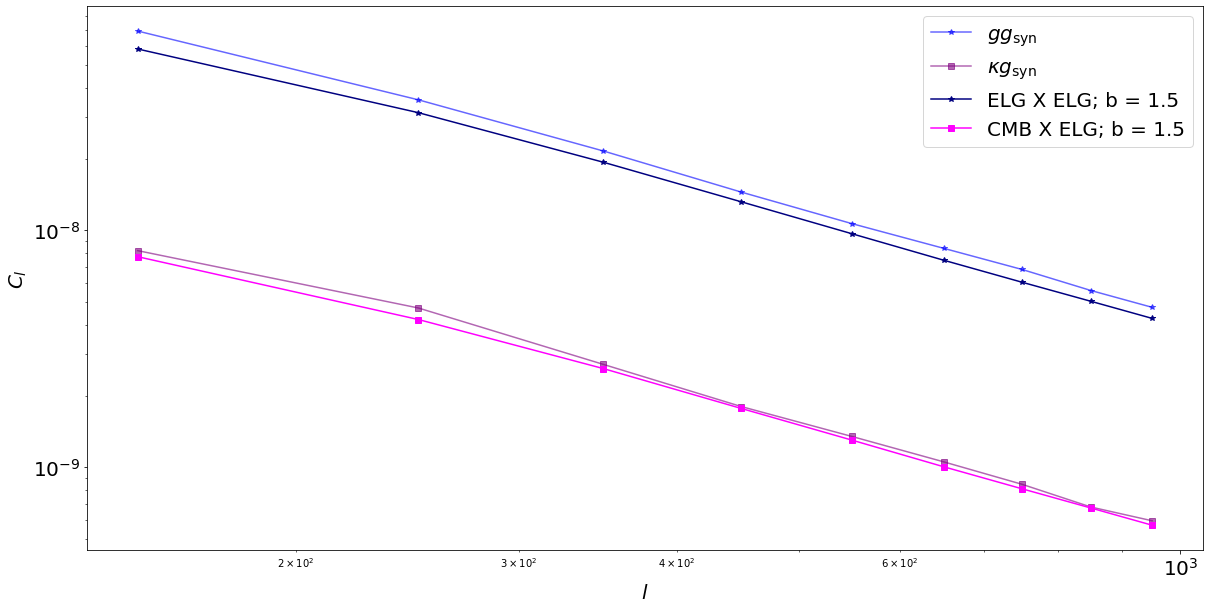

In [48]:
alpha = 0.6
plt.figure(figsize = fsize)
#plt.loglog(ell[ell > LMIN], clkk_syn[ell > LMIN], label = r'$\kappa \kappa_{\rm syn}$', c = "r", marker = "o")
plt.loglog(ELL[ELL > LMIN], CLgg_syn[ELL > LMIN], label = r'$gg_{\rm syn}$', c = "b", marker = "*", alpha = alpha)
plt.loglog(ELL[ELL > LMIN], CLkg_syn[ELL > LMIN], label = r'$\kappa g_{\rm syn}$', c = "purple", marker = "s", alpha = alpha)

#plt.loglog(lb[lb > LMIN], skylens_kk[lb > LMIN], 'ro', ls = '-', label = "CMB X CMB", c = 'salmon')
#plt.loglog(lb[lb > LMIN], skylens_gg1[lb > LMIN], 'b*', ls = '-', label = "ELG X ELG; b = 1", c = 'royalblue')
#plt.loglog(lb[lb > LMIN], skylens_kg1[lb > LMIN], 'ms', ls = '-', label = "CMB X ELG; b = 1", c = 'darkviolet')

plt.loglog(lb[lb > LMIN], skylens_gg15[lb > LMIN], 'b*', ls = '-', label = "ELG X ELG; b = 1.5", c = 'navy')
plt.loglog(lb[lb > LMIN], skylens_kg15[lb > LMIN], 'ms', ls = '-', label = "CMB X ELG; b = 1.5", c = 'fuchsia')

plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C_{l}$", fontsize = fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)

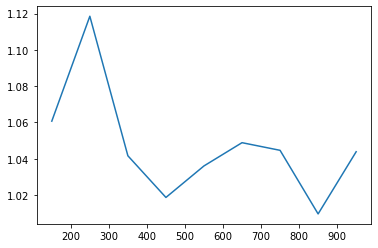

In [51]:
plt.plot(ELL[ELL > LMIN], CLkg_syn[ELL > LMIN]/skylens_kg15[lb > LMIN])

In [52]:
np.mean(CLkg_syn[ELL > LMIN]/skylens_kg15[lb > LMIN])

1.0469674033504086